## German Traffic Sign Classifier using a Convolutional Neuron Network

In this Python project example, <br>we will build a deep neural network model that can classify traffic signs present in the image into different categories.<br> With this model, we are able to read and understand traffic signs which are a very important task for all autonomous vehicles.

In [1]:
# Importing Required Libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense


## Data Exploration and Analysis

In [2]:
# csv file of training data
train_df=pd.read_csv('Train.csv')
train_df.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png

### Class Distribution of training data 
### There are 43 traffic sign classes and 39,209 training images in our german dataset



In [3]:
print("Number of training images :",len(train_df['ClassId'])  )
print("Number of classes : 43")

Number of training images : 39209
Number of classes : 43


###  sign_names.csv holds the classid of the traffic sign names

In [4]:
sign_name_df = pd.read_csv('sign_names.csv', index_col='ClassId')
sign_name_df.head(7)

SignName
ClassId                             
0               Speed limit (20km/h)
1               Speed limit (30km/h)
2               Speed limit (50km/h)
3               Speed limit (60km/h)
4               Speed limit (70km/h)
5               Speed limit (80km/h)
6        End of speed limit (80km/h)

In [5]:
print('Below dataframe shows the no of occurence of images of respective class id of our train dataset : ')
sign_name_df['Occurence'] = [sum(train_df['ClassId']==c) for c in range(43)]
sign_name_df.sort_values('ClassId')

Below dataframe shows the no of occurence of images of respective class id of our train dataset : 


SignName  Occurence
ClassId                                                              
0                                     Speed limit (20km/h)        210
1                                     Speed limit (30km/h)       2220
2                                     Speed limit (50km/h)       2250
3                                     Speed limit (60km/h)       1410
4                                     Speed limit (70km/h)       1980
5                                     Speed limit (80km/h)       1860
6                              End of speed limit (80km/h)        420
7                                    Speed limit (100km/h)       1440
8                                    Speed limit (120km/h)       1410
9                                               No passing       1470
10            No passing for vehicles over 3.5 metric tons       2010
11                   Right-of-way at the next intersection       1320
12                                           Priority road       2100
13                                                   Yield       2160
14                                                    Stop        780
15                                             No vehicles        630
16                Vehicles over 3.5 metric tons prohibited        420
17                                                No entry       1110
18                                         General caution       1200
19                             Dangerous curve to the left        210
20                            Dangerous curve to the right        360
21                                            Double curve        330
22                                              Bumpy road        390
23                                           Slippery road        510
24                               Road narrows on the right        270
25                                               Road work       1500
26                                         Traffic signals        600
27                                             Pedestrians        240
28                                       Children crossing        540
29                                       Bicycles crossing        270
30                                      Beware of ice/snow        450
31                                   Wild animals crossing        780
32                     End of all speed and passing limits        240
33                                        Turn right ahead        689
34                                         Turn left ahead        420
35                                              Ahead only       1200
36                                    Go straight or right        390
37                                     Go straight or left        210
38                                              Keep right       2070
39                                               Keep left        300
40                                    Roundabout mandatory        360
41                                       End of no passing        240
42       End of no passing by vehicles over 3.5 metric ...        240

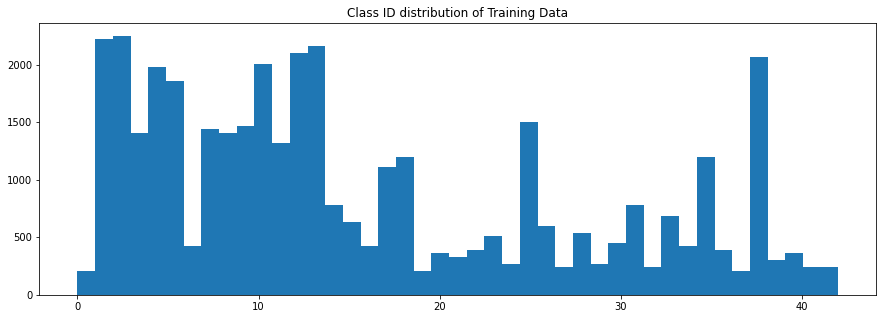

The distribution of classes are very skewed.


In [6]:
plt.figure(figsize=(15, 5))
plt.title('Class ID distribution of Training Data')
plt.hist(train_df['ClassId'], bins=43)
plt.show()
print('The distribution of classes are very skewed.')

## Sample Images (Random)

In [32]:
def get_samples(image_data, num_samples,class_id=None):
    """
    Randomly selecting image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]

    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Path', 'ClassId']].values

print('Below are the random path and class id from train dataset ')
sample_data = get_samples(train_df, 20)
sample_data


Below are the random path and class id from train dataset 


array([['Train/4/00004_00017_00013.png', 4],
       ['Train/12/00012_00050_00015.png', 12],
       ['Train/4/00004_00027_00022.png', 4],
       ['Train/27/00027_00000_00010.png', 27],
       ['Train/9/00009_00004_00010.png', 9],
       ['Train/5/00005_00043_00027.png', 5],
       ['Train/10/00010_00006_00026.png', 10],
       ['Train/22/00022_00009_00016.png', 22],
       ['Train/4/00004_00050_00026.png', 4],
       ['Train/9/00009_00040_00023.png', 9],
       ['Train/5/00005_00012_00029.png', 5],
       ['Train/10/00010_00064_00009.png', 10],
       ['Train/16/00016_00007_00001.png', 16],
       ['Train/26/00026_00018_00027.png', 26],
       ['Train/18/00018_00019_00019.png', 18],
       ['Train/21/00021_00008_00021.png', 21],
       ['Train/17/00017_00012_00007.png', 17],
       ['Train/13/00013_00039_00011.png', 13],
       ['Train/41/00041_00007_00016.png', 41],
       ['Train/18/00018_00011_00017.png', 18]], dtype=object)

In [42]:
def show_images(image_data, cols):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        """
        Read image file into numpy array (RGB)
        """
        image = plt.imread(image_file)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
    plt.show()

Below are 20 random sample images from the train set.


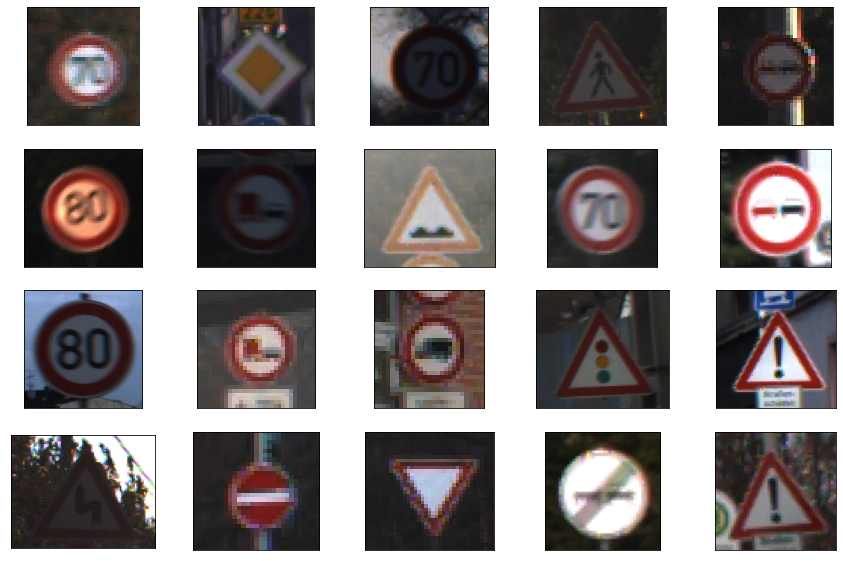

In [43]:
print('Below are 20 random sample images from the train set.')
show_images(sample_data, cols=5)


## Analysing the images of any particular class for better understanding of dataset

Speed limit (50km/h)


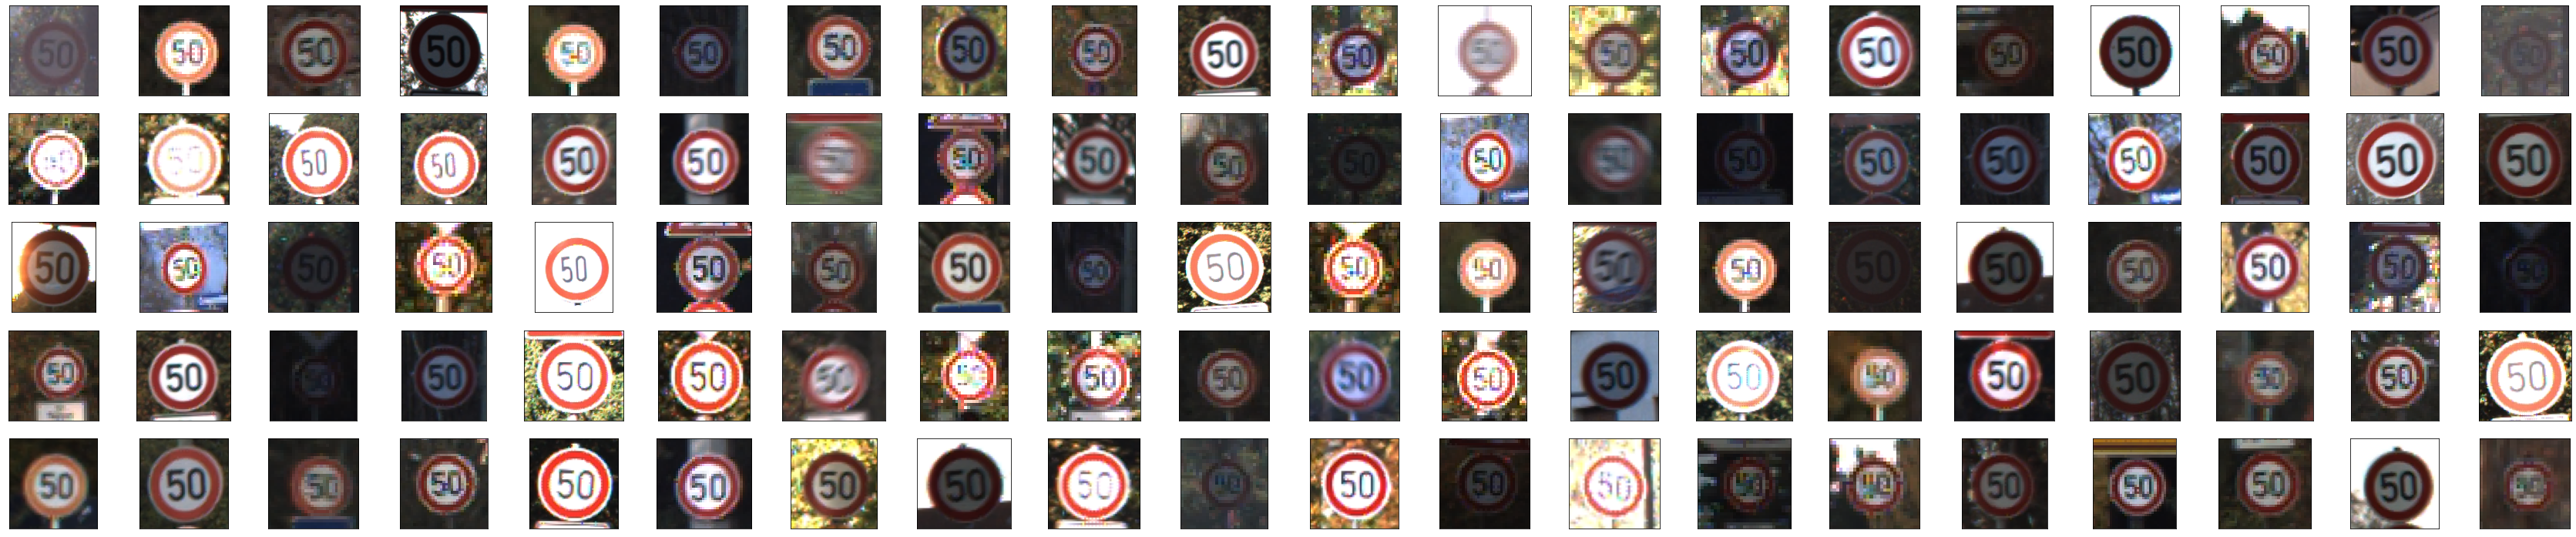

In [35]:
print(sign_name_df.iloc[2]['SignName'])
show_images(get_samples(train_df, 100, class_id=2), cols=20)

### Looking at the Above sample images, the following image characteristics are observed:

The images comes in different sizes<br> 
The darkness / brightness of those images are fairly random<br>
The images may be slightly rotated<br> <br>
The first point will be handled in the image pre-processing, and the 2nd and 3rd points will be handled in the image augmentation.<br>
<br>And definately images will vary huge i

## Data Preprocessing

In [69]:

data = []
labels = []
classes = 43
cur_path = os.getcwd()


In [70]:
#Retrieving the images and their labels
for i in range(classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

print('All Classes images have been retrieved')

All Classes images have been retrieved


In [71]:

#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)


(39209, 30, 30, 3) (39209,)


## Train and Validation Data set


In [76]:
#Splitting training and testing dataset

X_train, X_test, Y_train, Y_test = train_test_split(data,labels,test_size=0.2,random_state=42, shuffle=True)


print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [77]:

#Converting the labels into one hot encoding
Y_train = to_categorical(Y_train, 43)
Y_test = to_categorical(Y_test, 43)


## Model Implementation


### Model Architecture
Our model is adapted from LeNet by Yann LeCun.<br> It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing. <br>It can handle hand-written characters very well.

Source: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

In [78]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))


In [79]:
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [82]:
epochs = 15
history = model.fit(X_train, Y_train, batch_size=32, epochs=epochs, validation_data=(X_test, Y_test))



Epoch 1/15
981/981 [==============================] - 39s 39ms/step - loss: 3.2832 - accuracy: 0.3324 - val_loss: 0.3930 - val_accuracy: 0.9041
Epoch 2/15
981/981 [==============================] - 45s 46ms/step - loss: 0.6530 - accuracy: 0.8137 - val_loss: 0.1862 - val_accuracy: 0.9533
Epoch 3/15
981/981 [==============================] - 42s 43ms/step - loss: 0.3873 - accuracy: 0.8892 - val_loss: 0.1141 - val_accuracy: 0.9684
Epoch 4/15
981/981 [==============================] - 42s 43ms/step - loss: 0.2997 - accuracy: 0.9168 - val_loss: 0.0775 - val_accuracy: 0.9796
Epoch 5/15
981/981 [==============================] - 43s 44ms/step - loss: 0.2445 - accuracy: 0.9344 - val_loss: 0.0727 - val_accuracy: 0.9820
Epoch 6/15
981/981 [==============================] - 45s 46ms/step - loss: 0.2594 - accuracy: 0.9283 - val_loss: 0.1074 - val_accuracy: 0.9713
Epoch 7/15
981/981 [==============================] - 41s 41ms/step - loss: 0.2495 - accuracy: 0.9317 - val_loss: 0.1147 - val_accuracy:

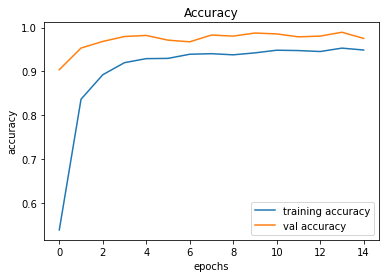

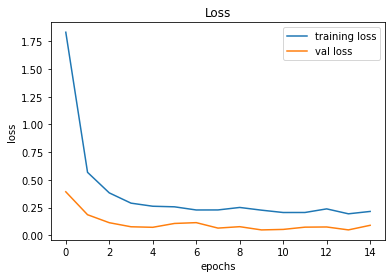

In [83]:
# plotting graphs for accuracy 

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# Model 2

## Data Normalization

In [84]:
X_train = X_train/255 
X_test = X_test/255

### Image Augmentation

In [85]:

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [86]:
#Building the model
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(rate=0.25))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(rate=0.25))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(rate=0.5))
model2.add(Dense(43, activation='softmax'))


In [87]:
#Compilation of the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [88]:
batch_size = 32
epochs = 15

history = model2.fit(aug.flow(X_train,Y_train,batch_size=batch_size),
                    epochs=epochs, validation_data=(X_test, Y_test) )

Epoch 1/15
981/981 [==============================] - 49s 49ms/step - loss: 2.7867 - accuracy: 0.2331 - val_loss: 0.4681 - val_accuracy: 0.8568
Epoch 2/15
981/981 [==============================] - 43s 43ms/step - loss: 0.8479 - accuracy: 0.7343 - val_loss: 0.1326 - val_accuracy: 0.9697
Epoch 3/15
981/981 [==============================] - 43s 44ms/step - loss: 0.4733 - accuracy: 0.8562 - val_loss: 0.0578 - val_accuracy: 0.9851
Epoch 4/15
981/981 [==============================] - 43s 44ms/step - loss: 0.3221 - accuracy: 0.8986 - val_loss: 0.0665 - val_accuracy: 0.9786
Epoch 5/15
981/981 [==============================] - 45s 46ms/step - loss: 0.2567 - accuracy: 0.9220 - val_loss: 0.0435 - val_accuracy: 0.9887
Epoch 6/15
981/981 [==============================] - 43s 44ms/step - loss: 0.2278 - accuracy: 0.9323 - val_loss: 0.0240 - val_accuracy: 0.9935
Epoch 7/15
981/981 [==============================] - 43s 44ms/step - loss: 0.2017 - accuracy: 0.9399 - val_loss: 0.0186 - val_accuracy:

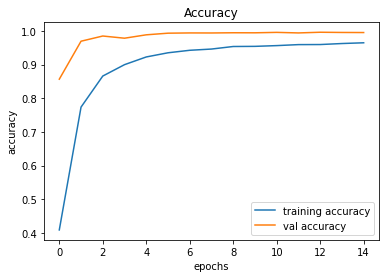

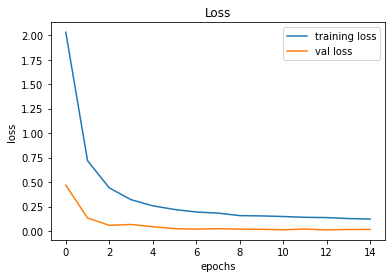

In [89]:
# plotting graphs for accuracy 

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# Model 3

In [90]:
# Building model

model3 = Sequential()

model3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(30,30,3)))
model3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(rate=0.25))

model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(rate=0.25))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(rate=0.5))
model3.add(Dense(43, activation='softmax'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)         

In [91]:
# Compiling model

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [92]:
batch_size = 32
epochs = 15

history = model3.fit(aug.flow(X_train,Y_train,batch_size=batch_size),
                    epochs=epochs, validation_data=(X_test, Y_test) )

Epoch 1/15
981/981 [==============================] - 53s 53ms/step - loss: 2.6473 - accuracy: 0.2567 - val_loss: 0.4304 - val_accuracy: 0.8693
Epoch 2/15
981/981 [==============================] - 50s 51ms/step - loss: 0.7388 - accuracy: 0.7609 - val_loss: 0.0809 - val_accuracy: 0.9764
Epoch 3/15
981/981 [==============================] - 45s 46ms/step - loss: 0.3632 - accuracy: 0.8824 - val_loss: 0.0368 - val_accuracy: 0.9908
Epoch 4/15
981/981 [==============================] - 48s 49ms/step - loss: 0.2528 - accuracy: 0.9218 - val_loss: 0.0214 - val_accuracy: 0.9949
Epoch 5/15
981/981 [==============================] - 49s 50ms/step - loss: 0.2013 - accuracy: 0.9375 - val_loss: 0.0150 - val_accuracy: 0.9971
Epoch 6/15
981/981 [==============================] - 48s 49ms/step - loss: 0.1655 - accuracy: 0.9498 - val_loss: 0.0105 - val_accuracy: 0.9972
Epoch 7/15
981/981 [==============================] - 46s 47ms/step - loss: 0.1323 - accuracy: 0.9581 - val_loss: 0.0107 - val_accuracy:

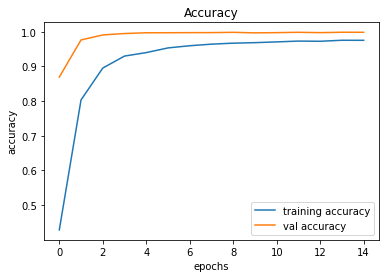

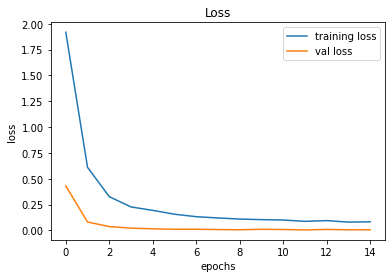

In [93]:
# plotting graphs for accuracy 

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


## Test Dataset

In [94]:
# prepairng test data

test = pd.read_csv(cur_path + '/Test.csv')

labels_test = test["ClassId"].values

#Retrieving the images and their labels
path = os.path.join(cur_path,'test')
images = os.listdir(path)
data_test=[]
for a in images:
    try:
        image = Image.open(path + '/'+ a)
        image = image.resize((30,30))
        image = np.array(image)
        data_test.append(image)
    except:
        print("Error loading image")


In [102]:
X_pred = np.array(data_test)

#normalizing 
X_pred = X_pred/255

In [105]:
# Predicting

pred = model3.predict_classes(X_pred)


/home/divyansh/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [106]:
#testing accuracy on test dataset

from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(labels_test, pred)*100)

Test Data accuracy:  97.73555027711798


In [107]:
model3.save("./model_traffic_sign.h5")